## Gliding Wing Mechanics

By: Sam Hocking \
Updated: 5/10/2022

Terminology and equations:

Wing and airfoil
- Chold line: straight line from leading to trailing edge
- Chord length: $c$ length of chord line
- Quarter chord: $\frac{c}{4}$ conventional point to compute $L$, $D$, $M$
- Size: $S$ area of the wing
- Wingspan: $b$ length from wingtip to wingtip
- Aspect ratio: $AR = b2/S$

Atmosphere and flow
- Freestream (flow) velocity: $V_\infty$ [m/s]
- Relative wind: direction of $V_\infty$ (direction of vehicle travel)
- Angle of attack (between chord line and relative wind): $\alpha$
- Density of air: $\rho_\infty$ [kg/m3]
- Dynamic viscosity of air: $\mu_\infty$ [kg/(m·s)]
- Dynamic pressure: $q_\infty = \frac{1}{2} \rho_\infty V_\infty^2$ [kg/(m·s2)]
- Reynolds Number ($x$ distance from leading edge): $Re_x = \frac{\rho_\infty V_\infty x}{\mu_\infty}$

Aerodynamic force and moment
- Coefficient of lift: $c_l$
- Coefficient of drag: $c_d$
- Coefficient of moment: $c_m$
- Lift: $L = q_\infty S c_l$
- Drag: $D = q_\infty S c_d$
- Moment: $M = q_\infty S c c_m$

Imports, basic unit conversion rate declarations, and class initializations. We will use the SI engineering standard atmosphere for density and viscosity of air at various altitudes, the NACA 653-018 airfoil profile, and the Northrop YB-49 flying wing aircraft as our modeling classes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from scipy.integrate import odeint
from scipy.optimize import brentq
from gliding import *

g = 9.81
m_per_ft = 0.3048
deg_per_radian = 180/np.pi

standard_atmos = atmosphere('atmosphere.csv')
naca653018 = airfoil(polar_files = ['naca653018_polar_Re15k_clean.csv','naca653018_polar_Re5mm_clean.csv', 'naca653018_polar_Re10mm_clean.csv', 'naca653018_polar_Re24mm_clean.csv'],
                     Re_list = np.array([15e3, 5e6, 10e6, 24e6]),
                     name='NACA 653-018')
yb49 = airframe(c=38.24 * m_per_ft,
                cg_offset = np.array([30.7074 * m_per_ft, 0]),
                wingspan = 172 * m_per_ft,
                wing_area = 2 * 2036.91 * m_per_ft**2,
                m = 60500)

#### NACA 653-108 Polars

Plot the $c_l$, $c_d$, $c_m$ coefficients and $\frac{c_l}{c_d}$ ratio vs. $\alpha$. The graphs themselves are called polars.

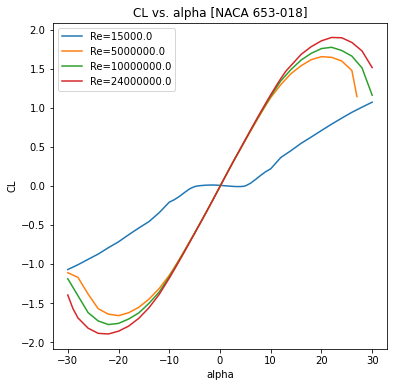

In [2]:
naca653018.plot('alpha','CL')

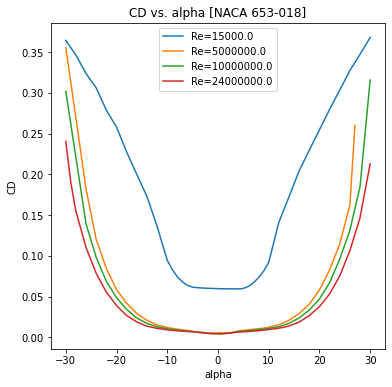

In [3]:
naca653018.plot('alpha','CD')

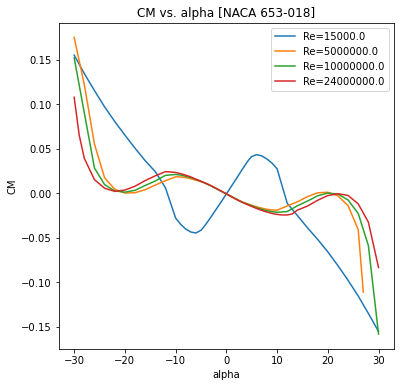

In [4]:
naca653018.plot('alpha','CM')

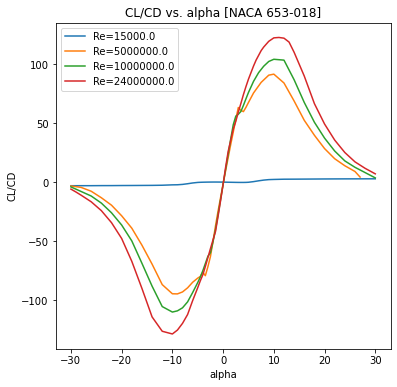

In [5]:
naca653018.plot('alpha','CL/CD')

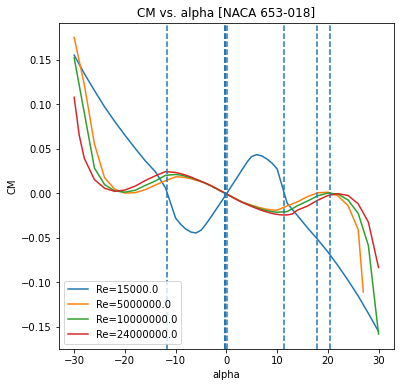

In [6]:
naca653018.plot_cm_fixed_pts()

#### Freefall and stable glide analysis

First, we compare the aircraft in freefall with no aerodynamic lift or drag (or normal air resistance) to a stable glide with the aircraft trimmed at a constant angle of attack. The angle of attack is the angle between the airfoil's chord line and the relative wind (direction of travel in this case). 

We'll look at three initial velocity scenarios with two different angles of attack. $\alpha$=0.125 degrees is a fixed point at Re=15k (much lower than would be actually experienced (17-24mm) but has a fixed point with positive Cl/Cd). $\alpha$=0.5 degrees has ~10x higher Cl/Cd due to the very high lift slope of the surface (which is why it was used for a high capacity bomber)

$c_m$ "roots": $\alpha$ at which $c_m=0$

In [7]:
naca653018.cm_roots

[array([-11.65294118,   0.125     ,  11.40721649]),
 array([-0.33333333, 17.86046512, 20.43902439]),
 array([-0.33333333]),
 array([-0.26666667])]

In [8]:
vect0_scen1 = [0,9000,0.125/deg_per_radian,160,0,0]
vect0_scen2 = [0,9000,0.125/deg_per_radian,80,0,0]
vect0_scen3 = [0,9000,0.125/deg_per_radian,10,0,0]
vect0_scen4 = [0,9000,0.5/deg_per_radian,160,0,0]
vect0_scen5 = [0,9000,0.5/deg_per_radian,80,0,0]
vect0_scen6 = [0,9000,0.5/deg_per_radian,10,0,0]

Reynold's number for 160m/s initial velocity and 9000m initial elevation

In [9]:
ac_y = vect0_scen1[1] + yb49.cg_ac_len*np.sin(vect0_scen1[2])
rho = lin_interp(standard_atmos.df, 'dens', 'alt', ac_y)
mu = lin_interp(standard_atmos.df, 'visc', 'alt', ac_y)
Re = rho * np.sqrt(vect0_scen1[3]**2 + vect0_scen1[4]**2) * yb49.c_qtr / mu
Re

14583074.6469761

Approximate Cl/Cd at $\alpha$=0.125

In [10]:
Re_interp(naca653018.Re_list, naca653018.polar_df_arr, 'CL/CD', vect0_scen1[2]*180/(np.pi), Re)

1.5968401427918202

Approximate Cl/Cd at $\alpha$=0.5

In [11]:
Re_interp(naca653018.Re_list, naca653018.polar_df_arr, 'CL/CD', vect0_scen4[2]*180/(np.pi), Re)

11.684401974959513

I chose $\alpha$=0.125 instead a realistic/actual high Re fixed point of $\alpha$=-0.33 because Cl/Cd at $\alpha$=-0.33 is very negative:

In [20]:
Re_interp(naca653018.Re_list, naca653018.polar_df_arr, 'CL/CD', -0.33*180/(np.pi), Re)

-48.392010982413225

In [12]:
yb49_freefall_s1 = freefall(standard_atmos, naca653018, yb49, vect0=vect0_scen1)
yb49_freefall_s2 = freefall(standard_atmos, naca653018, yb49, vect0=vect0_scen2)
yb49_freefall_s3 = freefall(standard_atmos, naca653018, yb49, vect0=vect0_scen3)
yb49_stable_glide_s1 = stable_glide(standard_atmos, naca653018, yb49, vect0=vect0_scen1)
yb49_stable_glide_s2 = stable_glide(standard_atmos, naca653018, yb49, vect0=vect0_scen2)
yb49_stable_glide_s3 = stable_glide(standard_atmos, naca653018, yb49, vect0=vect0_scen3)
yb49_stable_glide_s4 = stable_glide(standard_atmos, naca653018, yb49, vect0=vect0_scen4)
yb49_stable_glide_s5 = stable_glide(standard_atmos, naca653018, yb49, vect0=vect0_scen5)
yb49_stable_glide_s6 = stable_glide(standard_atmos, naca653018, yb49, vect0=vect0_scen6)

obj_array = [
    yb49_freefall_s1,
    yb49_freefall_s2,
    yb49_freefall_s3,
    yb49_stable_glide_s1,
    yb49_stable_glide_s2,
    yb49_stable_glide_s3,
    yb49_stable_glide_s4,
    yb49_stable_glide_s5,
    yb49_stable_glide_s6
]

for obj in obj_array:
    obj.integrate(0,600,0.1)

Plot 'zoomed in' vehicle paths to compare with freefall. Notice that the low Cl/Cd for $\alpha$=0.125 doesn't outperform freefall by much. Trimming the aircraft to $\alpha$=0.5 significantly increases lift and glide performance as a result of the significant increase in $\frac{c_l}{c_d}$ (notice the steep slope of the $\frac{c_l}{c_d}$ polar). 

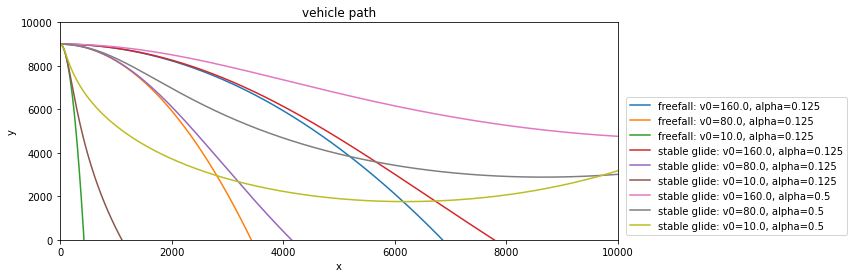

In [13]:
fig, ax = plt.subplots(figsize=(10,4))
for obj in obj_array:
    plt.plot(obj.results[:,1], obj.results[:,2], label=f'{obj.type}: v0={np.linalg.norm(np.array([obj.vect0[3],obj.vect0[4]]))}, alpha={obj.vect0[2]*deg_per_radian}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim([0,10000])
ax.set_xlim([0,10000])
plt.legend(loc='lower right', bbox_to_anchor=(1.42, 0))  
plt.title('vehicle path')
plt.show()

Plot 'zoomed out' paths to see the long term gliding of the vehicle for $\alpha$=0.5

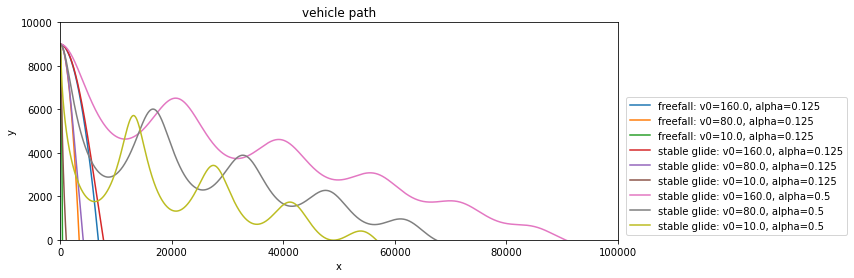

In [14]:
fig, ax = plt.subplots(figsize=(10,4))
for obj in obj_array:
    plt.plot(obj.results[:,1], obj.results[:,2], label=f'{obj.type}: v0={np.linalg.norm(np.array([obj.vect0[3],obj.vect0[4]]))}, alpha={obj.vect0[2]*deg_per_radian}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim([0,10000])
ax.set_xlim([0,100000])
plt.legend(loc='lower right', bbox_to_anchor=(1.42, 0))  
plt.title('vehicle path')
plt.show()

The velocity plot below is slightly fictitious since it completely ignores the collision with the ground. However, it illustrates the long-term equilibrium glide velocity

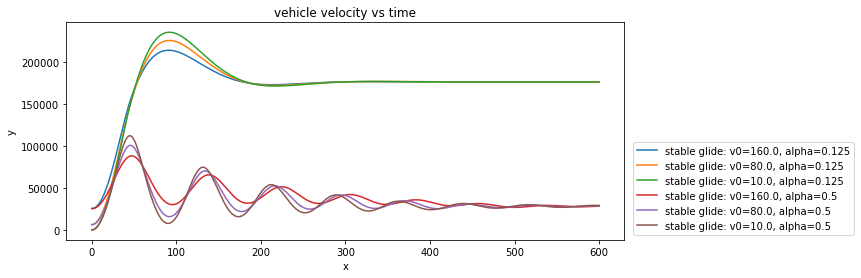

In [15]:
fig, ax = plt.subplots(figsize=(10,4))
for i in range(3,len(obj_array)):
    obj = obj_array[i]
    plt.plot(obj.results[:,0], obj.results[:,-1], label=f'{obj.type}: v0={np.linalg.norm(np.array([obj.vect0[3],obj.vect0[4]]))}, alpha={obj.vect0[2]*deg_per_radian}')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(loc='lower right', bbox_to_anchor=(1.42, 0))  
plt.title('vehicle velocity vs time')
plt.show()

#### Dynamic gliding analysis

Now, we remove the assumption that the aircraft remains trimmed (without cost) at a static angle of attack. Instead, the aircraft is subject to the moment generated by the wing under lift and drag forces. The total moment on the center of gravity is equal to  $ M_{cg}=M_{c/4}+ l L \cos{\alpha} - l D \sin{\alpha} $ where $l$ is the distance (length of torque lever arm) between the center of gravity ($cg$) and the quarter chord (an approximation of the aerodynamic center), and the wing is mounted at zero inclination angle.

In [16]:
vect0_scen7 = [0,9000,0.125/deg_per_radian,100,0,0]
vect0_scen8 = [0,9000,0.125/deg_per_radian,80,0,0]
vect0_scen9 = [0,9000,0.125/deg_per_radian,60,0,0]

In [17]:
yb49_stable_glide_s7 = stable_glide(standard_atmos, naca653018, yb49, vect0=vect0_scen7)
yb49_stable_glide_s8 = stable_glide(standard_atmos, naca653018, yb49, vect0=vect0_scen8)
yb49_stable_glide_s9 = stable_glide(standard_atmos, naca653018, yb49, vect0=vect0_scen9)
yb49_dynamic_glide_s1 = dynamic_glide(standard_atmos, naca653018, yb49, vect0=vect0_scen7)
yb49_dynamic_glide_s2 = dynamic_glide(standard_atmos, naca653018, yb49, vect0=vect0_scen8)
yb49_dynamic_glide_s3 = dynamic_glide(standard_atmos, naca653018, yb49, vect0=vect0_scen9)

obj_array = [
    yb49_stable_glide_s7,
    yb49_stable_glide_s8,
    yb49_stable_glide_s9,
    yb49_dynamic_glide_s1,
    yb49_dynamic_glide_s2,
    yb49_dynamic_glide_s3
]

for obj in obj_array:
    obj.integrate(0,8,0.1)

Notice the unstable behavior relative to the trimmed, stable glide. This may be the result of the NACA 653-018 airfoil having negative $c_l/c_d$ at its high Re stable fixed point ($c_m=0$), and the result of the additional lift and drag torque exerted through the lever arm (equal to 9.36m [80% of the chord]).

In [24]:
yb49.cg_ac_len, yb49.cg_ac_len / yb49.c

(9.35961552, 0.8030177824267781)

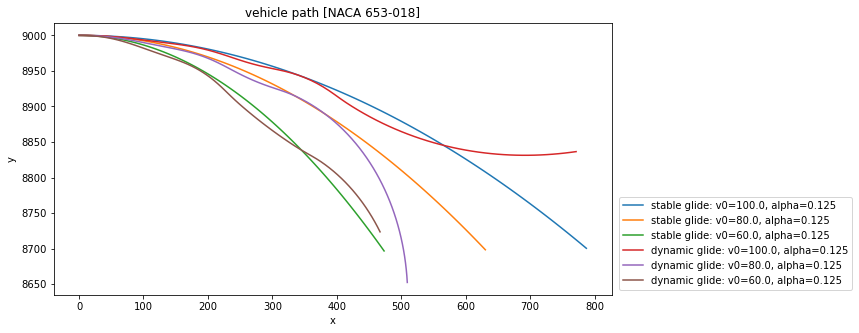

In [49]:
fig, ax = plt.subplots(figsize=(10,5))
for obj in obj_array:
    plt.plot(obj.results[:,1], obj.results[:,2], label=f'{obj.type}: v0={np.linalg.norm(np.array([obj.vect0[3],obj.vect0[4]]))}, alpha={obj.vect0[2]*deg_per_radian}')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(loc='lower right', bbox_to_anchor=(1.44, 0))  
plt.title('vehicle path [NACA 653-018]')
plt.show()

The angular acceleration of $\phi$ the angle of inclination of the aerodynamic center is equal to $\frac{M_{cg}}{m l^2}$. $ M_{cg}=M_{c/4}+ l L \cos{\alpha} - l D \sin{\alpha} $ so

$$\frac{d^2 \phi}{dt^2} = \frac{M_{c/4} + l L \cos{\alpha} - l D \sin{\alpha}}{m l^2} = \frac{\frac{M_{c/4}}{l} + L \cos{\alpha} - D \sin{\alpha}}{m l}$$

Suppose we could load the YB-49 differently such that the center of gravity is located at half the normal distance to the quarter chord.

In [32]:
yb49_alt = airframe(c=38.24 * m_per_ft,
                cg_offset = np.array([9.35961552/2, 0]),
                wingspan = 172 * m_per_ft,
                wing_area = 2 * 2036.91 * m_per_ft**2,
                m = 60500)

In [33]:
yb49_alt_stable_glide_s7 = stable_glide(standard_atmos, naca653018, yb49_alt, vect0=vect0_scen7)
yb49_alt_stable_glide_s8 = stable_glide(standard_atmos, naca653018, yb49_alt, vect0=vect0_scen8)
yb49_alt_stable_glide_s9 = stable_glide(standard_atmos, naca653018, yb49_alt, vect0=vect0_scen9)
yb49_alt_dynamic_glide_s1 = dynamic_glide(standard_atmos, naca653018, yb49_alt, vect0=vect0_scen7)
yb49_alt_dynamic_glide_s2 = dynamic_glide(standard_atmos, naca653018, yb49_alt, vect0=vect0_scen8)
yb49_alt_dynamic_glide_s3 = dynamic_glide(standard_atmos, naca653018, yb49_alt, vect0=vect0_scen9)

obj_array_alt = [
    yb49_alt_stable_glide_s7,
    yb49_alt_stable_glide_s8,
    yb49_alt_stable_glide_s9,
    yb49_alt_dynamic_glide_s1,
    yb49_alt_dynamic_glide_s2,
    yb49_alt_dynamic_glide_s3
]

for obj in obj_array_alt:
    obj.integrate(0,8,0.1)

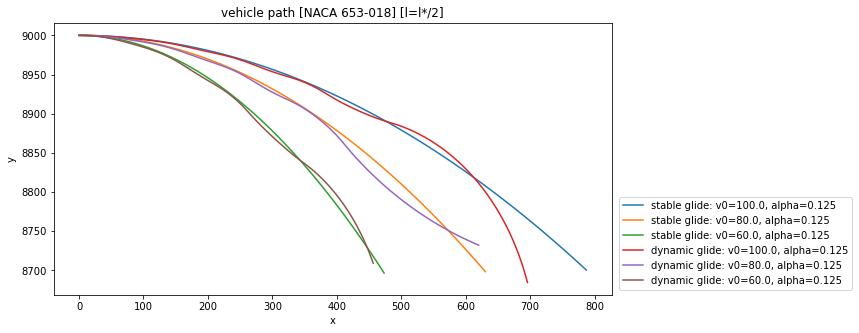

In [50]:
fig, ax = plt.subplots(figsize=(10,5))
for obj in obj_array_alt:
    plt.plot(obj.results[:,1], obj.results[:,2], label=f'{obj.type}: v0={np.linalg.norm(np.array([obj.vect0[3],obj.vect0[4]]))}, alpha={obj.vect0[2]*deg_per_radian}')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(loc='lower right', bbox_to_anchor=(1.44, 0))  
plt.title('vehicle path [NACA 653-018] [l=l*/2]')
plt.show()

Suppose we could load the YB-49 differently such that the center of gravity is located at one quarter the normal distance to the quarter chord.

In [37]:
yb49_alt_2 = airframe(c=38.24 * m_per_ft,
                cg_offset = np.array([9.35961552/4, 0]),
                wingspan = 172 * m_per_ft,
                wing_area = 2 * 2036.91 * m_per_ft**2,
                m = 60500)

In [38]:
yb49_alt_2_stable_glide_s7 = stable_glide(standard_atmos, naca653018, yb49_alt_2, vect0=vect0_scen7)
yb49_alt_2_stable_glide_s8 = stable_glide(standard_atmos, naca653018, yb49_alt_2, vect0=vect0_scen8)
yb49_alt_2_stable_glide_s9 = stable_glide(standard_atmos, naca653018, yb49_alt_2, vect0=vect0_scen9)
yb49_alt_2_dynamic_glide_s1 = dynamic_glide(standard_atmos, naca653018, yb49_alt_2, vect0=vect0_scen7)
yb49_alt_2_dynamic_glide_s2 = dynamic_glide(standard_atmos, naca653018, yb49_alt_2, vect0=vect0_scen8)
yb49_alt_2_dynamic_glide_s3 = dynamic_glide(standard_atmos, naca653018, yb49_alt_2, vect0=vect0_scen9)

obj_array_alt_2 = [
    yb49_alt_2_stable_glide_s7,
    yb49_alt_2_stable_glide_s8,
    yb49_alt_2_stable_glide_s9,
    yb49_alt_2_dynamic_glide_s1,
    yb49_alt_2_dynamic_glide_s2,
    yb49_alt_2_dynamic_glide_s3
]

for obj in obj_array_alt_2:
    obj.integrate(0,8,0.1)

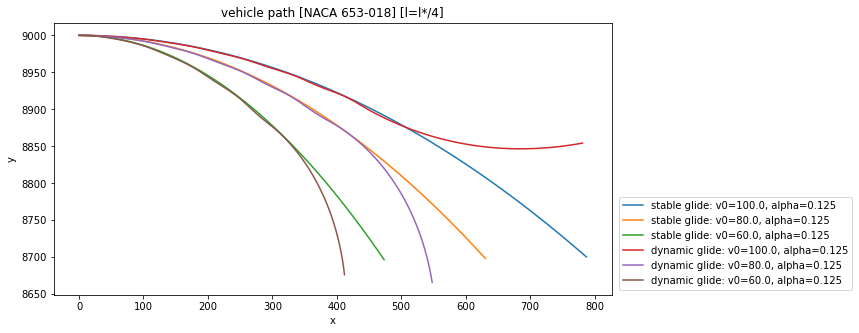

In [51]:
fig, ax = plt.subplots(figsize=(10,5))
for obj in obj_array_alt_2:
    plt.plot(obj.results[:,1], obj.results[:,2], label=f'{obj.type}: v0={np.linalg.norm(np.array([obj.vect0[3],obj.vect0[4]]))}, alpha={obj.vect0[2]*deg_per_radian}')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(loc='lower right', bbox_to_anchor=(1.44, 0))  
plt.title('vehicle path [NACA 653-018] [l=l*/4]')
plt.show()

Suppose we could load the YB-49 differently such that the center of gravity is located at twice the normal distance to the quarter chord (ignoring the spatial constraints of the actual airframe)

In [41]:
yb49_alt_3 = airframe(c=38.24 * m_per_ft,
                cg_offset = np.array([9.35961552*2, 0]),
                wingspan = 172 * m_per_ft,
                wing_area = 2 * 2036.91 * m_per_ft**2,
                m = 60500)

In [42]:
yb49_alt_3_stable_glide_s7 = stable_glide(standard_atmos, naca653018, yb49_alt_3, vect0=vect0_scen7)
yb49_alt_3_stable_glide_s8 = stable_glide(standard_atmos, naca653018, yb49_alt_3, vect0=vect0_scen8)
yb49_alt_3_stable_glide_s9 = stable_glide(standard_atmos, naca653018, yb49_alt_3, vect0=vect0_scen9)
yb49_alt_3_dynamic_glide_s1 = dynamic_glide(standard_atmos, naca653018, yb49_alt_3, vect0=vect0_scen7)
yb49_alt_3_dynamic_glide_s2 = dynamic_glide(standard_atmos, naca653018, yb49_alt_3, vect0=vect0_scen8)
yb49_alt_3_dynamic_glide_s3 = dynamic_glide(standard_atmos, naca653018, yb49_alt_3, vect0=vect0_scen9)

obj_array_alt_3 = [
    yb49_alt_3_stable_glide_s7,
    yb49_alt_3_stable_glide_s8,
    yb49_alt_3_stable_glide_s9,
    yb49_alt_3_dynamic_glide_s1,
    yb49_alt_3_dynamic_glide_s2,
    yb49_alt_3_dynamic_glide_s3
]

for obj in obj_array_alt_3:
    obj.integrate(0,8,0.1)

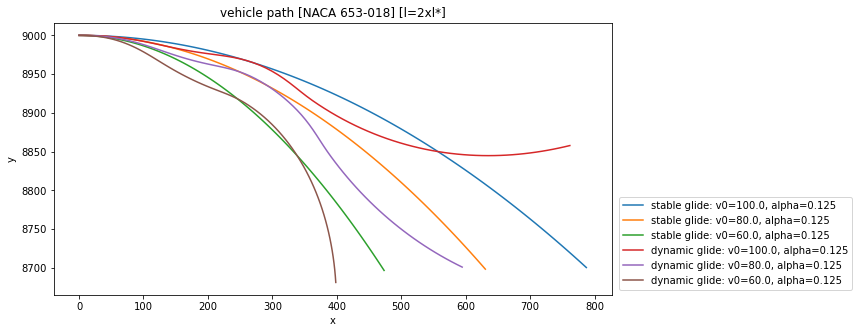

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
for obj in obj_array_alt_3:
    plt.plot(obj.results[:,1], obj.results[:,2], label=f'{obj.type}: v0={np.linalg.norm(np.array([obj.vect0[3],obj.vect0[4]]))}, alpha={obj.vect0[2]*deg_per_radian}')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(loc='lower right', bbox_to_anchor=(1.44, 0))  
plt.title('vehicle path [NACA 653-018] [l=2xl*]')
plt.show()

It is difficult to determine the results of this variation. Qualitatively, it seems that halving the distance between the quarter chord and the center of gravity does increase stability (at least in the very short run), but halving it again is counterproductive. It is important to note that only very short (~8 sec) simulations of the unstable flight were possible before numerical issues caused blow-up.